In [2]:
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.ensemble import IsolationForest, ExtraTreesRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance
from sklearn.cluster import MiniBatchKMeans
from umap import UMAP

import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore")

## ModelData

In [ ]:
from pathlib import Path
from typing import List, Optional, Literal, Union, Dict, Any

import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


class ModelData:
    """Class for managing dataset splits and feature/target extraction.

    Args:
        data (pd.DataFrame): The dataset.
        features (List[str]): List of feature column names.
        target (Optional[str]): Name of the target column.

    Attributes:
        data (pd.DataFrame): The dataset.
        target (Optional[str]): Name of the target column.
        features (List[str]): List of feature column names.
        index_sets (Dict[str, List]): Dictionary storing train, test, and validation indices.
    """

    @staticmethod
    def default_index_set(data: pd.DataFrame) -> dict:
        """Generate default train, test, and validation indices.

        Args:
            data (pd.DataFrame): The input data for which to generate indices.

        Returns:
            dict: A dictionary containing three keys: 'train', 'test', and 'valid', each associated with a list of indices.
        """
        return {"train": list(data.index), "test": [], "valid": []}

    def __init__(
        self,
        data: Union[pd.DataFrame, Path, str],
        features: List[str],
        target: Optional[str] = None,
        read_kwargs: Dict[str, Any] = None,
    ):
        """
        Initialize the Dataset class.

        Parameters:
        data (Union[pd.DataFrame, Path, str]): The data source, which can be a pandas DataFrame,
            a file path (str or Path) to a CSV or Parquet file, or a string representing the file path.
        features (List[str]): A list of column names representing the features in the dataset.
        target (Optional[str]): The name of the target column in the dataset. Defaults to None if
            the dataset is used for unsupervised learning or feature engineering.
        read_kwargs (Dict[str, Any]): Additional keyword arguments to be passed to the file reading
            functions (pd.read_csv or pd.read_parquet). Defaults to an empty dictionary.

        Raises:
        ValueError: If the file format is not supported (only CSV and Parquet are supported).
        """
        data = Path(data) if isinstance(data, str) else data
        if isinstance(data, Path):
            if read_kwargs is None:
                read_kwargs = {}
            if data.suffix == ".csv":
                data = pd.read_csv(data, **read_kwargs)
            elif data.suffix == ".parquet":
                data = pd.read_parquet(data, **read_kwargs)
            else:
                raise ValueError(
                    "Unsupported file format. Only CSV and Parquet are supported."
                )
        self.data = data
        self.features = features
        self.target: Optional[str] = target
        self.index_sets = self.default_index_set(self.data)

    @classmethod
    def load_california_housing_data(cls):
        """Load California housing data and initialize dataset attributes.

        This method fetches the California housing dataset, concatenates the features and target into a single DataFrame,
        sets the features and target attributes, and generates default train, test, and validation indices.

        Returns:
            Dataset: The initialized dataset object with the loaded data.
        """
        california_housing = fetch_california_housing(as_frame=True)
        data = pd.concat([california_housing.data, california_housing.target], axis=1)
        features = california_housing.feature_names
        target = california_housing.target.name
        return cls(data, features, target)

    def split_data(self, test_size: float = 0, valid_size: float = 0):
        """Split the dataset into train, test, and optionally validation sets.

        Args:
            test_size (float): Proportion of the dataset to include in the test split.
            valid_size (float): Proportion of the dataset to include in the validation split.
        """
        if test_size == 0 and valid_size == 0:
            self.index_sets = self.default_index_set(self.data)
        self.index_sets["train"], self.index_sets["test"] = train_test_split(
            list(self.data.index), test_size=test_size
        )
        if valid_size > 0:
            self.index_sets["train"], self.index_sets["valid"] = train_test_split(
                self.index_sets["train"], test_size=valid_size
            )

    def get_data(
        self,
        indexes_set: Literal["train", "test", "valid", "all"] = "all",
        fields_set: Literal["all", "features", "target"] = "all",
    ):
        """Retrieve data based on specified indexes and fields.

        Args:
            indexes_set (Literal["train", "test", "valid", "all"]): The set of indexes to retrieve.
            fields_set (Literal["all", "features", "target"]): The set of fields to retrieve.

        Returns:
            pd.DataFrame or pd.Series: The requested data subset.

        Raises:
            ValueError: If an invalid fields_set value is provided or if target is None.
        """
        if indexes_set == "all":
            indexes = list(self.data.index)
        else:
            indexes = self.index_sets[indexes_set]

        if fields_set == "all":
            return self.data.loc[indexes, :]
        elif fields_set == "features":
            return self.data.loc[indexes, self.features]
        elif fields_set == "target":
            return None if self.target is None else self.data.loc[indexes, self.target]
        else:
            raise ValueError("Invalid fields_set value or target is None.")

    def encode_categoricals(
        self,
        encoder,
        indexes_set: Literal["train", "test", "valid", "all"] = "all",
        **kwargs
    ):
        """Encode categorical features using the provided encoder."""
        categorical_features = self.get_data(
            indexes_set=indexes_set, fields_set="features"
        ).select_dtypes(include="object")
        encoded_features = encoder.fit_transform(categorical_features, **kwargs)
        self.data = self.data.drop(columns=categorical_features.columns)
        self.data = self.data.join(encoded_features)
        return encoder

    def scale_features(
        self, scaler, indexes_set: Literal["train", "test", "valid", "all"] = "all"
    ):
        scaled_data = scaler.fit_transform(self.get_data(indexes_set=indexes_set))
        scaled_data = pd.DataFrame(
            scaled_data,
            columns=self.get_data(indexes_set=indexes_set).columns,
            index=(
                self.index_sets[indexes_set]
                if indexes_set != "all"
                else self.data.index
            ),
        )
        self.data = self.data.drop(index=scaled_data.index)
        self.data = pd.concat(self.data, scaled_data, axis=1).sort_index()
        return scaler

    def __str__(self):
        return self.data.__str__()

    def __repr__(self):
        return self.data.__repr__()

    def _repr_html_(self):
        return self.data._repr_html_()

    def __len__(self):
        return len(self.data)


# Functions

## Outliers Functions

In [5]:
def gen_data_with_outliers(data_size: int, outliers_percent: float):
    """
    Generate a dataset with a specified percentage of outliers.

    Parameters:
    data_size (int): The total number of data points to generate.
    outliers_percent (float): The percentage of data points that should be outliers.

    Returns:
    pd.DataFrame: A DataFrame containing the generated data with outliers.
    """
    data = np.random.normal(0, 1, int(data_size * (1 - outliers_percent)))
    outliers = np.random.normal(10, 1, int(data_size * outliers_percent))
    return pd.DataFrame({"x": np.concatenate((data, outliers))})


# def mark_outliers(data: pd.DataFrame, target_field: str, outlier_field: str) -> pd.DataFrame:
#     """
#     Mark outliers in the DataFrame based on the target field and outlier field.

#     Parameters:
#     data (pd.DataFrame): The input DataFrame containing the data.
#     target_field (str): The name of the column to consider for outlier detection.
#     outlier_field (str): The name of the column that indicates the presence of outliers.

#     Returns:
#     pd.DataFrame: A new DataFrame with outliers marked as 1 if above the median and -1 if below the median.
#     """
#     median = data[target_field].median()
#     zero_data = data[data[outlier_field] == 1]
#     zero_data[outlier_field] = 0

#     outlier_data = data[data[outlier_field] == -1]
#     outlier_data[outlier_field] = outlier_data.apply(
#         lambda x: 1 if x[target_field] > median else -1, axis=1
#     )
#     return pd.concat([zero_data, outlier_data])


def outliers_plot_1d(
    data: pd.DataFrame,
    target_field: str,
    outlier_field: str,
    step=0.001,
    figsize=(15, 10),
):
    """
    Plot a 1-dimensional representation of data with outliers, colored by the outlier_field.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    target_field (str): The name of the field to analyze for outliers.
    outlier_field (str): The name of the field that indicates the presence of outliers.
    step (float): The step size for calculating quantiles. Default is 0.001.
    figsize (tuple): The size of the figure to plot. Default is (15, 10).

    The function creates a line plot where each point represents a quantile of the target_field.
    Points are colored based on the mode of the outlier_field for the range of data that falls
    between the quantiles defined by the step size.
    """
    plt.figure(figsize=figsize)
    c_map = {
        -1: "red",
        1: "black",
    }
    t_data = pd.DataFrame(
        {
            "x": np.arange(step, 1 + step, step),
        }
    )
    t_data["q"] = t_data["x"].apply(lambda x: np.quantile(data[target_field], x))
    t_data["color"] = t_data["x"].apply(
        lambda x: data.loc[
            (
                (data[target_field] > data[target_field].quantile(x - step))
                & (data[target_field] <= data[target_field].quantile(x))
            ),
            outlier_field,
        ].mode()
    )

    display(t_data)

    t_data["color"] = t_data["color"].apply(
        lambda x: (
            c_map.get(x) if isinstance(x, float) else (x[0] if len(x) > 0 else None)
        )
    )

    t_data = t_data.bfill()
    display(t_data)

    plt.scatter(
        t_data["x"],
        t_data["q"],
        c=t_data["color"],
        marker="s",
    )
    plt.title(f"Quantile {target_field} with colors based on {outlier_field}")
    plt.xlabel("Quantile")
    plt.ylabel("Value")
    plt.grid()
    plt.show()

## Metrics

In [6]:
from typing import Optional, Dict, Any

import numpy as np
import pandas as pd
from scipy.stats import norm, stats


def group_std(data: pd.DataFrame, target: str, group: str) -> pd.DataFrame:
    """
    Calculate the standard deviation for each group in the data.

    Parameters:
    data (pd.DataFrame): The input data containing the target and group columns.
    target (str): The column name of the target variable.
    group (str): The column name of the group variable.

    Returns:
    pd.DataFrame: A DataFrame with each group's size and variance, along with the total size and variance.
    """
    groups_var = data.groupby(group).agg(
        group_size=(target, "count"), var=(target, "var")
    )
    groups_var.loc["total"] = [len(data), data[target].var()]
    return groups_var


def strat_std(
    data: pd.DataFrame, target: str, group_col: str, strat: Optional[str] = None
) -> pd.DataFrame:
    """
    Calculate the stratified standard deviation for each group in the data.

    Parameters:
    data (pd.DataFrame): The input data containing the target, group, and stratification columns.
    target (str): The column name of the target variable.
    group (str): The column name of the group variable.
    strat (Optional[str], optional): The column name of the stratification variable. Defaults to None.

    Returns:
    pd.DataFrame: A DataFrame with each group's size and stratified variance, along with the total size and variance.
    """
    if not strat:
        return group_std(data, target, group_col)

    total_var = 0

    groups_var = data.groupby([group_col, strat]).agg(group_size=(target, "count"))
    groups_var[f"{target}_strat_var"] = 0

    for strat, strat_data in data.groupby(strat):
        total_strat_val = strat_data[target].var() * len(strat_data) / len(data)
        total_var += total_strat_val
        for group, group_strated_data in strat_data.groupby(group_col):
            group_strat_var = (
                group_strated_data[target].var()
                * len(group_strated_data)
                / len(groups_var.loc[group, "group_size"])
            )
            groups_var.loc[group, f"{target}_strat_var"] += (
                groups_var.loc[group, f"{target}_strat_var"] + group_strat_var
            )

    groups_var.loc["total"] = [len(data), total_var]
    return groups_var


def mde(
    data: pd.DataFrame,
    target: str,
    group: str,
    significance: float = 0.05,
    power: float = 0.8,
) -> float:
    """
    Calculate the Minimum Detectable Effect (MDE) for a given group in the data.

    Parameters:
    data (pd.DataFrame): The input data containing the target and group columns.
    target (str): The column name of the target variable.
    group (str): The column name of the group variable.
    significance (float, optional): The significance level for the MDE calculation. Defaults to 0.05.
    power (float, optional): The power for the MDE calculation. Defaults to 0.8.

    Returns:
    float: The calculated MDE value.
    """
    grouped_data = sorted(list(data.groupby(group)), key=lambda x: x[0])
    control_data = grouped_data[0][1][target]
    test_data = grouped_data[1][1][target]

    m = norm.ppf(1 - significance / 2) + norm.ppf(power)

    n_control, n_test = len(control_data), len(test_data)

    var_control, var_test = control_data.var(ddof=1), test_data.var(ddof=1)
    return m * np.sqrt(var_test / n_test + var_control / n_control)


def strat_mde(
    data: pd.DataFrame,
    target: str,
    group: str,
    strat: Optional[str] = None,
    significance: float = 0.05,
    power: float = 0.8,
) -> float:
    """
    Calculate the stratified Minimum Detectable Effect (MDE) for a given group in the data.

    Parameters:
    data (pd.DataFrame): The input data containing the target, group, and stratification columns.
    target (str): The column name of the target variable.
    group (str): The column name of the group variable.
    strat (Optional[str], optional): The column name of the stratification variable. Defaults to None.
    significance (float, optional): The significance level for the MDE calculation. Defaults to 0.05.
    power (float, optional): The power for the MDE calculation. Defaults to 0.8.

    Returns:
    float: The calculated stratified MDE value.
    """
    if not strat:
        return mde(data, target, group, significance, power)

    m = norm.ppf(1 - significance / 2) + norm.ppf(power)

    var_test, var_control = 0, 0

    for s, strat_data in data.groupby(strat):
        grouped_data = sorted(list(strat_data.groupby(group)), key=lambda x: x[0])
        control_data = grouped_data[0][1][target]
        test_data = grouped_data[1][1][target]

        n_control, n_test = len(control_data), len(test_data)
        strat_control_var = control_data.var(ddof=1) * len(control_data) / n_control
        strat_test_var = test_data.var(ddof=1) * len(test_data) / n_test

        var_control += strat_control_var
        var_test += strat_test_var

    return m * np.sqrt(var_test / n_test + var_control / n_control)


def data_loss(data: pd.DataFrame, group: str, filter_field: str) -> pd.DataFrame:
    """
    Calculate the data loss percentage after applying a filter.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the data.
    group (str): The column name to group the data by.
    filter_field (str): The column name to apply the filter on.

    Returns:
    pd.DataFrame: A DataFrame containing the original count, filtered count, and loss percentage for each group.
    """
    orig_data_count = data.groupby(group).agg(orig_count=(group, "count"))
    filtered_data_count = (
        data[data[filter_field] == 1]
        .groupby(group)
        .agg(filtered_count=(group, "count"))
    )
    data_count = orig_data_count.join(filtered_data_count)
    data_count.loc["total", "orig_count"] = len(data)
    data_count.loc["total", "filtered_count"] = len(data[data[filter_field] == 1])
    data_count["loss"] = 1 - data_count["filtered_count"] / data_count["orig_count"]
    return data_count


def ate(data: pd.DataFrame, target: str, group: str) -> float:
    """
    Calculate the Average Treatment Effect (ATE) for the given data.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the data.
    target (str): The column name of the target variable.
    group (str): The column name to group the data by.

    Returns:
    float: The calculated ATE value.
    """
    result = data.groupby(group).agg(ate=(target, "mean")).sort_index()
    return result.iloc[1, 0] - result.iloc[0, 0]


def ttest(
    data: pd.DataFrame, target: str, group: str, significance: float = 0.05
) -> Dict[str, Any]:
    """
    Perform a t-test between two groups in the data.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the data.
    target (str): The column name of the target variable.
    group (str): The column name to group the data by.
    significance (float): The significance level for the t-test.

    Returns:
    Dict[str, Any]: A dictionary containing the t-statistic, p-value, pass/fail status, mean difference, and relative mean difference.
    """
    grouped_data = sorted(list(data.groupby(group)), key=lambda x: x[0])
    control_data = grouped_data[0][1][target]
    test_data = grouped_data[1][1][target]

    stat, p_value = stats.ttest_ind(control_data, test_data)
    result = {
        "stat": stat,
        "p_value": p_value,
        "pass": p_value < significance,
        "mean_diff": test_data.mean() - control_data.mean(),
    }
    result["relative_mean_diff"] = result["mean_diff"] / control_data.mean()
    return result


def std_data_loss_tradeoff(
    data: pd.DataFrame, target: str, group: str, filter_field: str
) -> Dict[str, Any]:
    """
    Calculate the tradeoff between standard deviation and data loss.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the data.
    target (str): The column name of the target variable.
    group (str): The column name to group the data by.
    filter_field (str): The column name to apply the filter on.

    Returns:
    Dict[str, Any]: A dictionary containing the original standard deviation, filtered standard deviation, data loss, standard deviation ratio, and tradeoff value.
    """
    result = {
        "std_original": group_std(data, target, group).loc["total", "var"],
        "std_filtered": group_std(data[data[filter_field] == 1], target, group).loc[
            "total", "var"
        ],
        "data_loss": data_loss(data, group, filter_field).loc["total", "loss"],
    }
    result["relative_std_diff"] = 1 - result["std_filtered"] / result["std_original"]
    result["tradeoff"] = result["relative_std_diff"] * np.power(
        1 - result["data_loss"], 7
    )
    return result

## Outlier Comparison Functions

In [7]:
@dataclass
class DefaultModelForComparison:
    """
    Data class to store the default configuration of a model for comparison.

    Attributes:
        model_class: The class of the model.
        default_kwargs: Default keyword arguments for the model.
        tested_parameter_name: The name of the parameter to be tested.
    """

    model_class: type
    default_kwargs: Dict[str, Any]
    tested_parameter_name: str

    def create_model(self, tested_parameter_value: Any) -> Any:
        """
        Creates an instance of the model with the tested parameter value.

        Args:
            tested_parameter_value: The value of the parameter to be tested.

        Returns:
            An instance of the model with the specified parameter value.
        """
        return self.model_class(
            **self.default_kwargs,
            **{self.tested_parameter_name: tested_parameter_value},
        )


def outliers_algorithm_testing(data: ModelData, model) -> None:
    """
    Tests an outlier detection algorithm on the given data and model.

    Args:
        data: The data to be used for testing.
        model: The model to be used for outlier detection.
    """
    key = model.__class__.__name__
    data.data[key] = model.fit_predict(
        data.get_data("train", "features").values.reshape(-1, 1)
    )
    # data.data = mark_outliers(data.data, data.features[0], key)
    display(data.data[key].value_counts(normalize=True))
    outliers_plot_1d(data.data, data.features[0], key)


def calc_dot_for_comparison(data: ModelData, model) -> Tuple[float, float, float]:
    """
    Calculates the standard deviation reduction for a given model and data.

    Args:
        data: The data to be used for comparison.
        model: The model to be used for comparison.

    Returns:
        A tuple containing the original standard deviation, new standard deviation, and standard deviation reduction.
    """
    x = data.features[0]
    data.data["dot"] = model.fit_predict(
        data.get_data("train", "features").values.reshape(-1, 1)
    )
    # data.data = mark_outliers(data.data, x, "dot")
    return std_data_loss_tradeoff(data.data, "x", "group", "dot")


def models_comparison(
    data: ModelData,
    models: List[DefaultModelForComparison],
    tested_parameter_values: List,
) -> pd.DataFrame:
    """
    Compares multiple models with different parameter values.

    Args:
        data: The data to be used for comparison.
        models: A list of models to be compared.
        tested_parameter_values: A list of parameter values to be tested.

    Returns:
        A DataFrame containing the results of the comparison.
    """
    result_table_list = []
    for v in tqdm(tested_parameter_values):
        for model in models:
            m = model.create_model(v)
            metrics = calc_dot_for_comparison(data, m)
            result_table_list += [
                {
                    "model": model.model_class.__name__,
                    "tested_parameter_value": v,
                    "relative_std_diff": metrics["relative_std_diff"],
                    "std_data_loss_tradeoff": metrics["tradeoff"],
                }
            ]
    return pd.DataFrame(result_table_list)


def show_models_comparison_resaults(result_table: pd.DataFrame) -> None:
    """
    Displays the results of the models comparison.

    Args:
        result_table: A DataFrame containing the results of the comparison.
    """
    data_groups = dict(list(result_table.groupby("model")))
    sorted_data_groups = dict(sorted(data_groups.items()))
    for key, value in sorted_data_groups.items():
        sv = value.sort_values(by=["tested_parameter_value"])
        plt.plot(
            sv["tested_parameter_value"],
            sv["relative_std_diff"],
            label=f"{key} relative_std_diff",
            linestyle="dashed",
        )
        plt.plot(
            sv["tested_parameter_value"],
            sv["std_data_loss_tradeoff"],
            label=f"{key} std_data_loss_tradeoff",
        )
    plt.legend()
    plt.show()

## Interpretation functios

In [8]:
def etrp_importance(data: ModelData) -> pd.DataFrame:
    """
    Calculate permutation feature importance using Extra Trees Regressor.

    Parameters:
    data (ModelData): An object containing training and test datasets.

    Returns:
    pd.DataFrame: A DataFrame with feature importances, including mean and standard deviation.
    """
    # Initialize and train the model
    model = ExtraTreesRegressor(n_estimators=1000, n_jobs=-1)
    model.fit(data.get_data("train", "features"), data.get_data("train", "target"))
    result = permutation_importance(
        model,
        data.get_data("test", "features"),
        data.get_data("test", "target"),
        n_repeats=30,
    )
    return pd.DataFrame(
        data={
            "importances mean": result.importances_mean,
            "importances std": result.importances_std,
        },
        index=data.features,
    ).sort_values(by="importances mean", ascending=False)


def feature_importance_plot(importances: pd.DataFrame):
    """
    Plot permutation feature importances.

    Parameters:
    importances (pd.DataFrame): A DataFrame containing feature importances with mean and standard deviation.
    """
    importances = importances.sort_values(by="importances mean", ascending=False)
    diff = importances["importances mean"].sort_values(ascending=True).diff()
    plt.bar(
        importances.index,
        importances["importances mean"],
        yerr=importances["importances std"],
        alpha=0.7,
    )
    plt.plot(diff.index, diff, color="black", alpha=0.7)
    plt.xticks(rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Permutation Importances of Features")
    plt.show()


def comparison_of_dist_by_group(data: pd.DataFrame, group_column: str, columns=None):
    columns = columns or data.columns
    columns = list(columns)
    columns.remove(group_column)

    fig, axs = plt.subplots(len(columns), 1, figsize=(11 * len(columns), 10))
    if len(columns) == 1:
        axs = [axs]
    for i, col in enumerate(columns):
        sns.histplot(
            data,
            x=col,
            ax=axs[i],
            stat="percent",
            kde=True,
            alpha=0.5,
            hue=group_column,
            bins=100,
        )
        axs[i].set_title(col)

    plt.legend()
    plt.show()

# Outlers filters

In [9]:
class QuantileTailClipper:
    def __init__(
        self,
        contamination=None,
        learning_rate=0.001,
        max_iter=None,
        min_diff=None,
        algorithm="auto",
    ):
        self.contamination = contamination
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.min_diff = min_diff
        self.lower_quantile = 0
        self.upper_quantile = 1
        self.algorithm = algorithm

    @staticmethod
    def _calculate_diff(x: pd.Series, lower_quantile: float, upper_quantile: float):
        lv, uv = None, None
        if lower_quantile > 0:
            lv = x.quantile(lower_quantile)
        if upper_quantile < 1:
            uv = x.quantile(upper_quantile)
        cx = x.copy()
        if lv is not None:
            cx = cx[cx >= lv]
        if uv is not None:
            cx = cx[cx <= uv]
        return 1 - cx.std() / x.std()

    def fit(self, X: np.array, y=None):
        best_diff = 0
        best_i = 0
        iteration = 0

        x = pd.Series(X.flatten())
        if self.contamination:
            self.upper_quantile = 1 - self.contamination

            for i in np.arange(
                0, self.contamination + self.learning_rate, self.learning_rate
            ):
                i_lower_quantile = self.lower_quantile + i
                i_upper_quantile = self.upper_quantile + i
                diff = self._calculate_diff(x, i_lower_quantile, i_upper_quantile)
                if diff > best_diff:
                    best_diff = diff
                    best_i = i

                if self.max_iter:
                    iteration += 1
                    if iteration >= self.max_iter:
                        break

                if self.min_diff:
                    if best_diff < self.min_diff:
                        break

            self.lower_quantile += best_i
            self.upper_quantile += best_i

    def predict(self, X: np.ndarray) -> np.ndarray:
        x = pd.Series(X.flatten())
        r = (
            (
                (x >= x.quantile(self.lower_quantile))
                & (x <= x.quantile(self.upper_quantile))
            )
            * 1
        ).replace({0: -1})
        return r.values

    def fit_predict(self, X: np.ndarray, y=None) -> np.ndarray:
        self.fit(X)
        return self.predict(X)

## Gen data

,x
0,-0.310045
1,1.003020
2,-0.542756
3,0.994351
4,0.900578
...,...
1019995,0.000000
1019996,0.000000
1019997,0.000000
1019998,0.000000


,x,group
0,-0.310045,1
1,1.003020,0
2,-0.542756,1
3,0.994351,1
4,0.900578,0
...,...,...
1019995,0.000000,1
1019996,0.000000,0
1019997,0.000000,0
1019998,0.000000,1


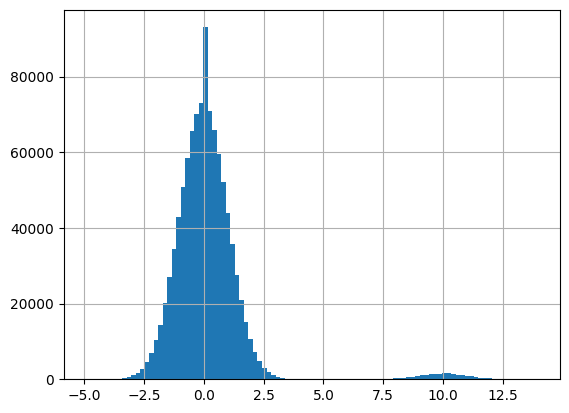

In [66]:
gen_data = gen_data_with_outliers(1_000_000, 0.02)
gen_data = pd.concat(
    [gen_data, pd.DataFrame({"x": [0] * 20_000})], axis=0, ignore_index=True
)

display(gen_data)

gen_data["x"].hist(bins=100)
data = ModelData(gen_data, "x")
data.split_data(0.5)
data.data["group"] = data.data.index.isin(data.index_sets["train"]) * 1
data.index_sets = ModelData.default_index_set(data.data)
data

# Quantile Tail Clipper 

QuantileTailClipper
 1    0.99
-1    0.01
Name: proportion, dtype: float64

,x,q,color
0,0.001,-3.070762,1.0
1,0.002,-2.868076,1.0
2,0.003,-2.730214,1.0
3,0.004,-2.632447,1.0
4,0.005,-2.552949,1.0
...,...,...,...
995,0.996,10.823593,-1.0
996,0.997,11.012478,-1.0
997,0.998,11.255218,-1.0
998,0.999,11.616483,-1.0


,x,q,color
0,0.001,-3.070762,black
1,0.002,-2.868076,black
2,0.003,-2.730214,black
3,0.004,-2.632447,black
4,0.005,-2.552949,black
...,...,...,...
995,0.996,10.823593,red
996,0.997,11.012478,red
997,0.998,11.255218,red
998,0.999,11.616483,red


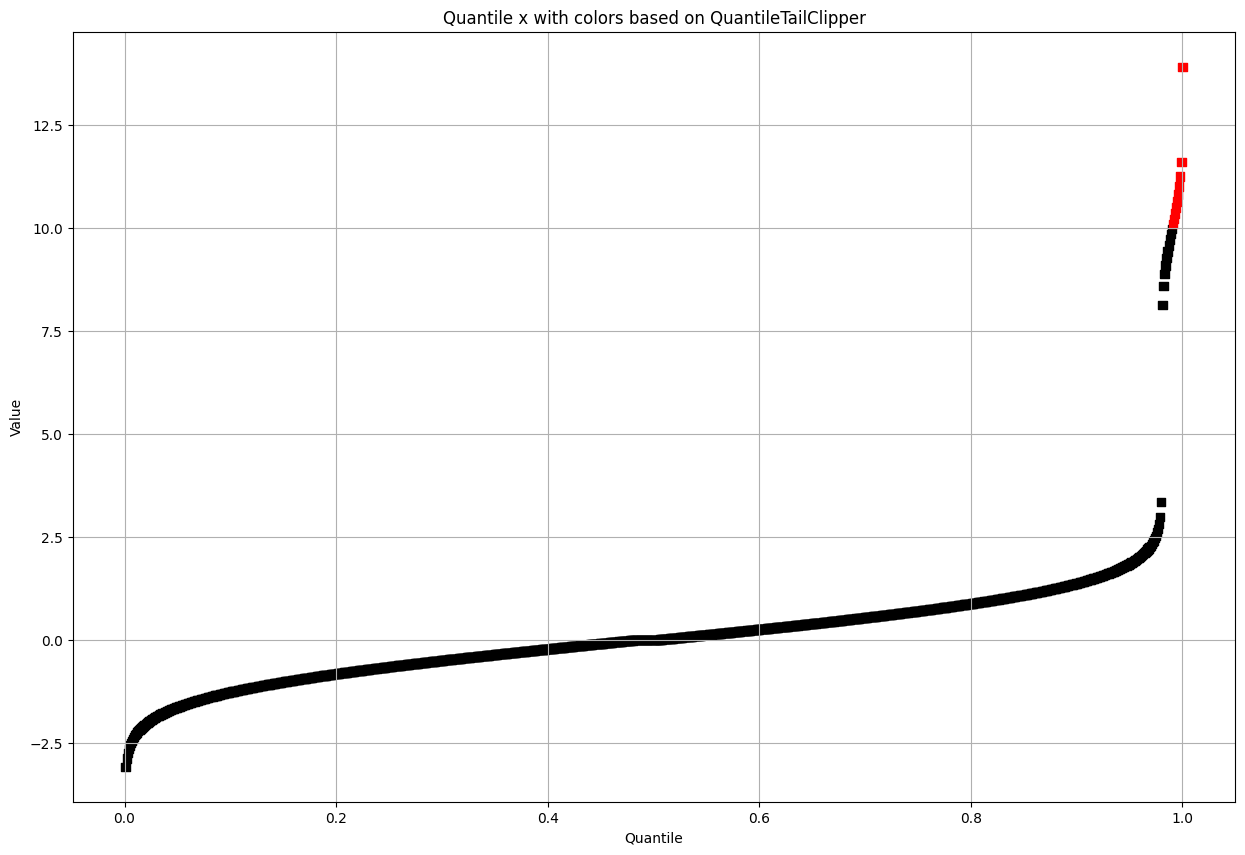

In [67]:
model = QuantileTailClipper(contamination=0.01)
outliers_algorithm_testing(data, model)

## Eleptic Envelope

EllipticEnvelope
 1    0.99
-1    0.01
Name: proportion, dtype: float64

,x,q,color
0,0.001,-3.088809,black
1,0.002,-2.868612,black
2,0.003,-2.736121,black
3,0.004,-2.642691,black
4,0.005,-2.571383,black
...,...,...,...
995,0.996,10.833028,red
996,0.997,11.024825,red
997,0.998,11.268058,red
998,0.999,11.664318,red


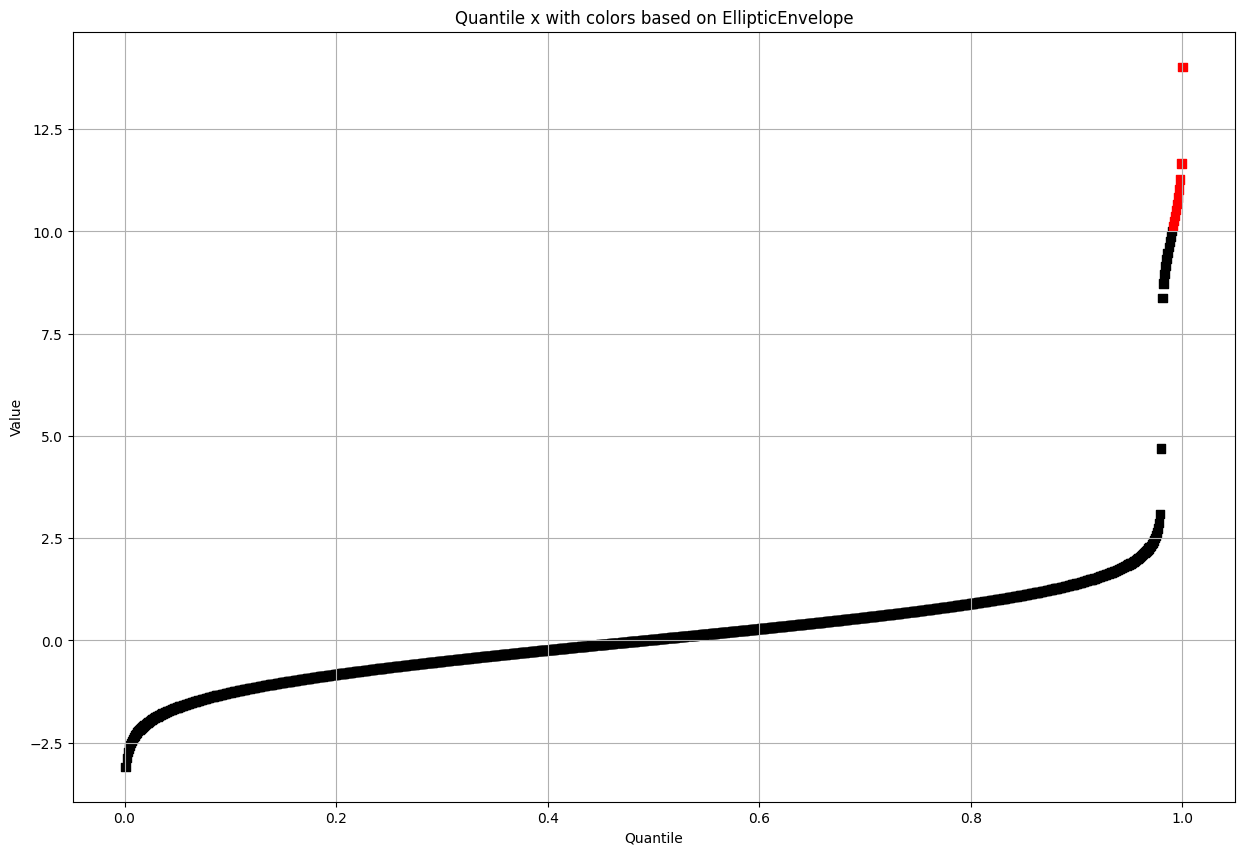

In [9]:
model = EllipticEnvelope(contamination=0.01)
outliers_algorithm_testing(data, model)

## Isolation Forest

IsolationForest
 1    0.990064
-1    0.009936
Name: proportion, dtype: float64

,x,q,color
0,0.001,-3.088809,black
1,0.002,-2.868612,black
2,0.003,-2.736121,black
3,0.004,-2.642691,black
4,0.005,-2.571383,black
...,...,...,...
995,0.996,10.833028,red
996,0.997,11.024825,red
997,0.998,11.268058,red
998,0.999,11.664318,red


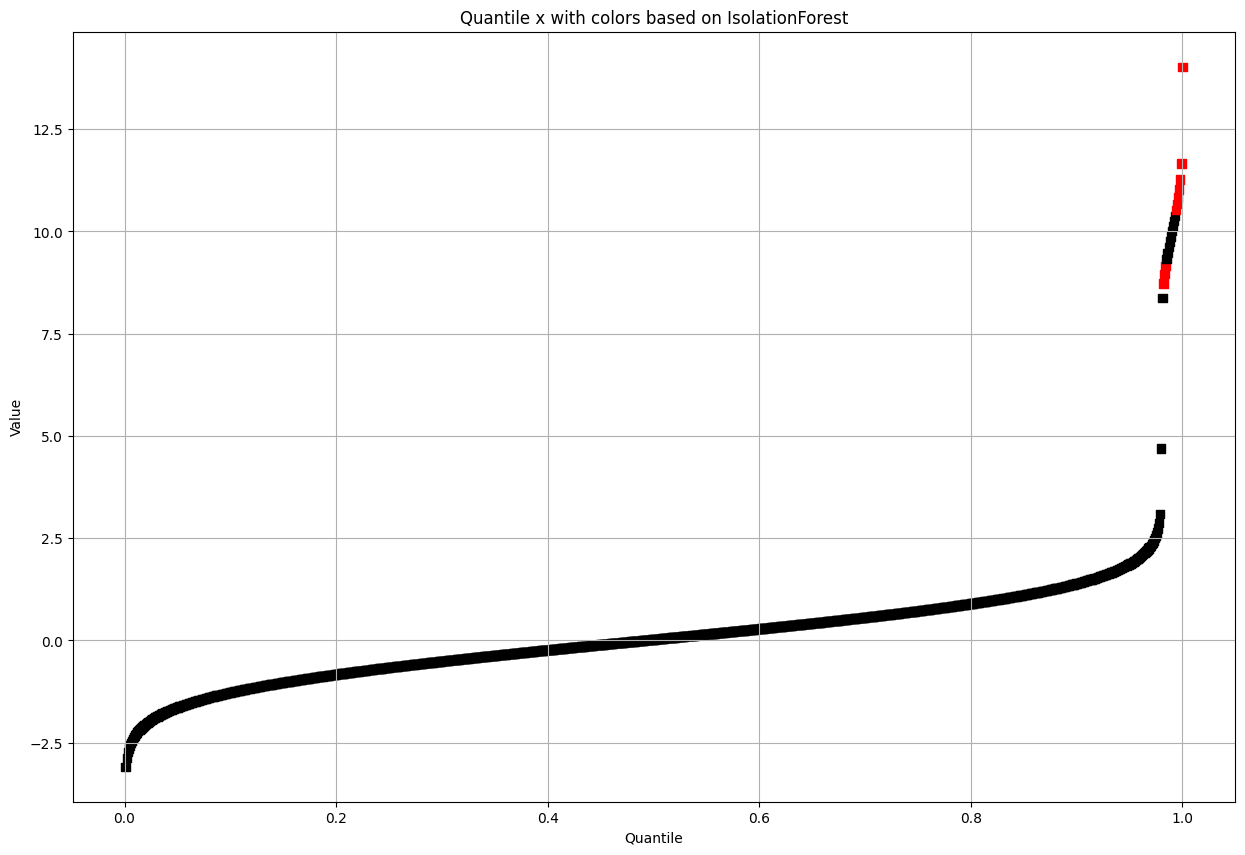

In [12]:
model = IsolationForest(n_jobs=-1, n_estimators=1000, contamination=0.01)
outliers_algorithm_testing(data, model)

## Compare Algorithms

  0%|          | 0/9 [00:00<?, ?it/s]

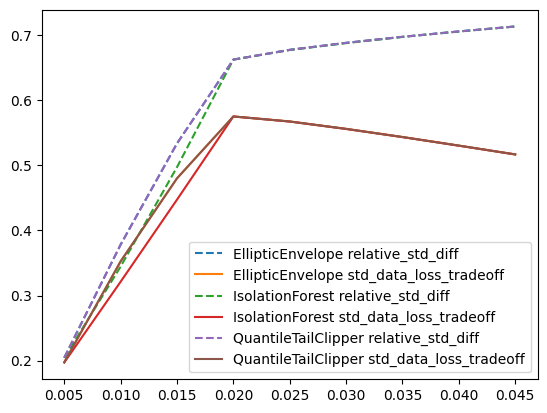

In [16]:
default_models = [
    DefaultModelForComparison(
        IsolationForest, {"n_estimators": 1000, "n_jobs": -1}, "contamination"
    ),
    DefaultModelForComparison(EllipticEnvelope, {}, "contamination"),
    # DefaultModelForComparison(LocalOutlierFactor, {'n_neighbors': 20}, 'contamination'),
    DefaultModelForComparison(QuantileTailClipper, {}, "contamination"),
]
comparison_table = models_comparison(
    data, default_models, np.arange(0.005, 0.05, 0.005)
)
show_models_comparison_resaults(comparison_table)

In [118]:
comparison_table = comparison_table.sort_values(
    "std_data_loss_tradeoff", ascending=False
)
comparison_table

,model,tested_parameter_value,relative_std_diff,std_data_loss_tradeoff
9,IsolationForest,0.020,0.661333,0.574120
10,EllipticEnvelope,0.020,0.661333,0.574120
11,QuantileTailClipper,0.020,0.661333,0.574120
12,IsolationForest,0.025,0.661335,0.553933
14,QuantileTailClipper,0.025,0.661310,0.553907
...,...,...,...,...
113,QuantileTailClipper,0.190,0.661341,0.151294
112,EllipticEnvelope,0.190,0.660640,0.151133
114,IsolationForest,0.195,0.661344,0.144908
115,EllipticEnvelope,0.195,0.661311,0.144870


In [ ]:
comparison_table.to_csv("outlier_filter_comparison_table.csv", index=False)

# Permutation Importance

In [ ]:
data = ModelData.load_california_housing_data()
data.split_data(test_size=0.2)
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
importances = etrp_importance(data)
importances

,importances mean,importances std
MedInc,0.803378,0.019062
Latitude,0.367211,0.008363
Longitude,0.317393,0.006995
AveOccup,0.139998,0.004533
HouseAge,0.071982,0.003973
AveRooms,0.017941,0.001011
AveBedrms,0.008406,0.000923
Population,0.004434,0.000649


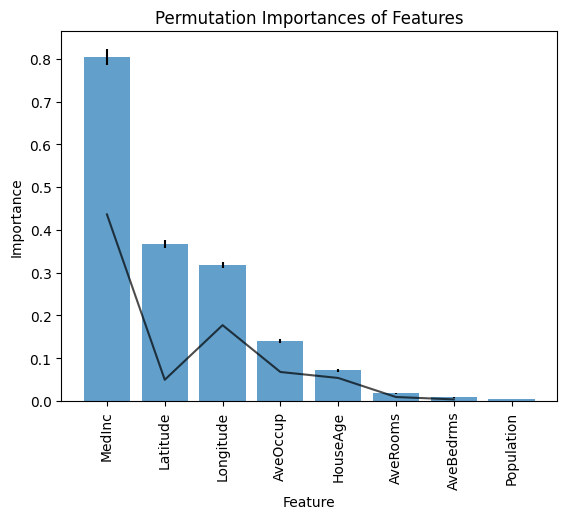

In [ ]:
feature_importance_plot(importances)

# Segmentation

## Mini batch knn

In [10]:
def one_segmentation_experiment(data: ModelData, model):
    data.data["cluster"] = model.fit_predict(data.get_data("all", "features"))
    display(data.data["cluster"].value_counts(normalize=True) * 100)
    data2d = pd.DataFrame(UMAP(n_jobs=-1).fit_transform(data.get_data("all", "features")), columns=["x", "y"])
    data2d["cluster"] = data.data["cluster"]
    sns.scatterplot(data=data2d, x="x", y="y", hue=data2d["cluster"], palette="viridis")
    data.data["group"] = 1
    d_std = strat_std(data.data, data.target, "group")
    d_sstd = strat_std(data.data, data.target, "group", "cluster")
    plt.show()
    result = {
        "std": d_std.loc["total", "var"],
        "strat std": d_sstd.loc["total", "MedHouseVal_strat_var"],
    }
    result["diff"] = 1 - result["strat std"]/result["std"]
    return result

def search_k(data: ModelData, max_k:int):
    result_arr = []
    for k in tqdm(range(2, max_k)):
        model = MiniBatchKMeans(n_clusters=k)
        data.data["cluster"] = model.fit_predict(data.get_data("all", "features"))
    
        result = {
            "k": k,
            "std": strat_std(data.data, data.target, "group").loc["total", "var"],
            "strat std": strat_std(data.data, data.target, "group", "cluster").loc["total", "MedHouseVal_strat_var"],
        }
        result["diff"] = 1 - result["strat std"]/result["std"]
        result_arr.append(result)
    return pd.DataFrame(result_arr)


In [11]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler

In [19]:
import pandas as pd

# Download the dataset
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv'
df = pd.read_csv(url)

data = ModelData(df, features=df.drop(columns=["tip"]).columns, target="tip")
data.split_data(test_size=0.2)
encoder = data.encode_categoricals(encoder=TargetEncoder(), y = data.get_data("all", "target"))
scaler = data.scale_features(scaler=StandardScaler())
data

KeyError: 'all'

In [ ]:
data = ModelData.load_california_housing_data()
data.split_data(test_size=0.2)
data.feature = data.data.columns
data.target = None

# mini_batch_kmeans = MiniBatchKMeans(n_clusters=10)
# one_segmentation_experiment(data=data, model=mini_batch_kmeans)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [12]:
data.target

'MedHouseVal'

In [76]:
k_scores = search_k(data=data, max_k=1000)
plt.plot(k_scores["k"], k_scores["diff"])

  0%|          | 0/998 [00:00<?, ?it/s]

KeyboardInterrupt: 